In [148]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from datetime import datetime


from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
#chilled water, electric, hot water, and steam meters

In [149]:
ashrae = pd.read_csv('ashrae_train.csv')
building = pd.read_csv('ashrae_building_metadata.csv')
weather =  pd.read_csv('ashrae_weather_train.csv')


In [150]:
ashrae.head(10)
building.head(10)
weather.head(10)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0
5,5,0,2016-01-01 00:00:00,0.0
6,6,0,2016-01-01 00:00:00,0.0
7,7,0,2016-01-01 00:00:00,0.0
8,8,0,2016-01-01 00:00:00,0.0
9,9,0,2016-01-01 00:00:00,0.0


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
5,0,2016-01-01 05:00:00,19.4,NaN,19.4,0.0,NaN,0.0,0.0
6,0,2016-01-01 06:00:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0
7,0,2016-01-01 07:00:00,21.1,NaN,21.1,0.0,1018.8,210.0,1.5
8,0,2016-01-01 08:00:00,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
9,0,2016-01-01 09:00:00,21.1,NaN,20.6,0.0,1019.0,290.0,1.5


## Understanding null values in 'building'

In [151]:
building_null = building.isnull().sum()*100/building.shape[0]
building_null.sort_values(ascending=False)

floor_count    75.500345
year_built     53.416149
square_feet     0.000000
primary_use     0.000000
building_id     0.000000
site_id         0.000000
dtype: float64

In [152]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [153]:
building1 = reduce_mem_usage(building)

Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [154]:
building1.dtypes

site_id           int8
building_id      int16
primary_use     object
square_feet      int32
year_built     float16
floor_count    float16
dtype: object

The floor_count and year_built columns have 75% and 53% nan values

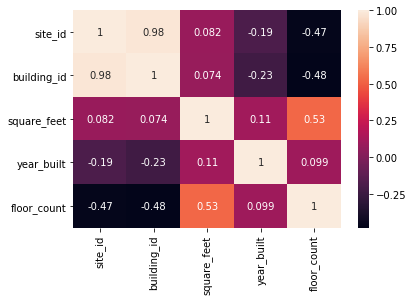

In [155]:
sns.heatmap(building1.corr(),annot=True)

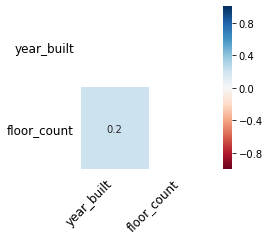

In [156]:
msno.heatmap(building,figsize=(3,3),fontsize=12) 

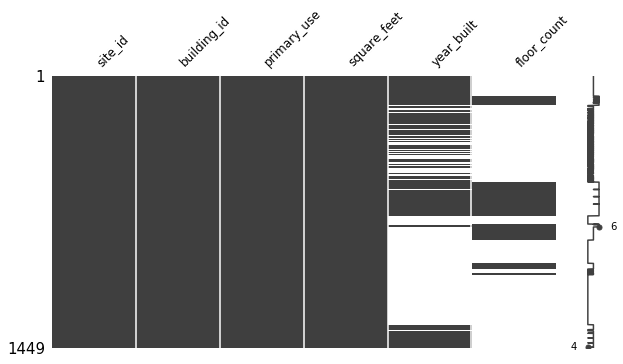

In [157]:
msno.matrix(building,figsize=(10,5),fontsize=12)

In [158]:
b = building1.copy(deep=True)
def binary(x):
    if np.isnan(x):
        return 0;
    else: 
        return 1;

b["year_binary"] = b.year_built.map(binary)     
b["floor_binary"] = b.floor_count.map(binary)    

b_year_null = b[b.year_built.isnull()]
b_year_notnull = b[~b.year_built.isnull()]

In [159]:
# plt.figure(figsize=(10,10))   ## how to change figsize ?
# g = sns.FacetGrid(b, col="year_binary")
# g = g.map(sns.distplot, "square_feet",color='c')

In [160]:
# b_year_null.primary_use.value_counts().plot(kind='bar')
# plt.show()
# b_year_notnull.primary_use.value_counts().plot(kind='bar')
# g = sns.catplot(x="primary_use", col="year_binary",data=b, kind="count");

In [161]:
# g = sns.catplot(x="site_id", col="year_binary",data=b, kind="count")

The missing values seem systematic wrt to year_built for the primary use of the building

In [162]:
# g = sns.FacetGrid(b, col="floor_binary")
# g = g.map(sns.distplot, "square_feet",color='c')

In [163]:
# b_floor_null = b[b.floor_count.isnull()]
# b_floor_notnull = b[~b.floor_count.isnull()]
# b_floor_null.primary_use.value_counts().plot(kind='bar')
# plt.show()
# b_floor_notnull.primary_use.value_counts().plot(kind='bar')
#g = sns.catplot(x="primary_use", col="floor_binary",data=b, kind="count")


In [164]:
#g = sns.catplot(x="site_id", col="floor_binary",data=b, kind="count")

In [165]:
floor_count = b["floor_count"].value_counts()
trace = go.Bar(x= floor_count.index,y = floor_count.values)

layout = go.Layout(title=go.layout.Title(text="Floor count of the buildings",x=0.5),font=dict(size=10),width=700,height=500,
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename="meter")

The floor_data is very skewed, a log transformation can be taken while modeling

## Understanding 'weather' data

In [166]:
weather_null = weather.isnull().sum()*100/weather.shape[0]
weather_null.sort_values(ascending = False)

cloud_coverage        49.489529
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dew_temperature        0.080845
air_temperature        0.039350
timestamp              0.000000
site_id                0.000000
dtype: float64

In [167]:
weather1 =reduce_mem_usage(weather)

Mem. usage decreased to  3.07 Mb (68.1% reduction)


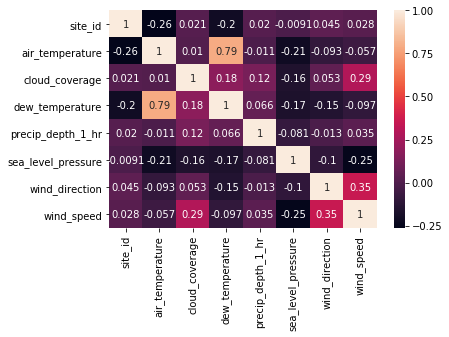

In [168]:
sns.heatmap(weather1.corr(),annot = True)

air_temperature and dew_temperature are highly correlated and hence drop dew_temperature

Dropping cloud_coverage and Precip_depth_1_hr as the columns have more than 20% nans

In [169]:
w = weather1.copy(deep=True)
w = w.drop(columns=['cloud_coverage','precip_depth_1_hr','dew_temperature'])

In [170]:
w_sea_null = w.sea_level_pressure.isnull().groupby([w['site_id']]).sum().astype(int).reset_index(name='count') 
#counts nan of sea_level_pressure
w_sea = w.groupby([w['site_id']])['timestamp'].count()

In [171]:
w_sea_null['count']*100/w_sea
w = w.drop(columns=['sea_level_pressure','wind_direction'])

0       0.967668
1       0.593404
2       0.500968
3       1.799544
4       0.831151
5     100.000000
6       1.992712
7       0.092872
8       0.967668
9       2.722096
10      1.605557
11      0.092872
12      0.639634
13      1.366276
14      1.253276
15      6.020819
dtype: float64

Site_id 5 has all the sea_level_pressure values missing

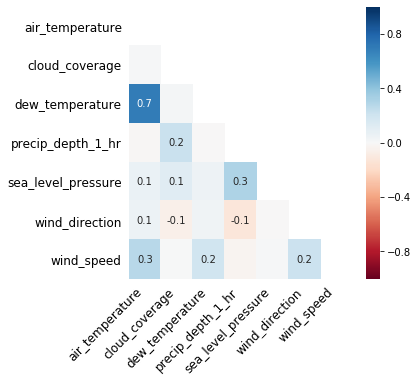

In [172]:
msno.heatmap(weather,figsize=(5,5),fontsize=12)  #useful to know of missing values are systematic
#w_windd_null = w.wind_direction.isnull().groupby([w['site_id']]).sum().astype(int).reset_index(name='count') 
#counts nan of sea_level_pressure

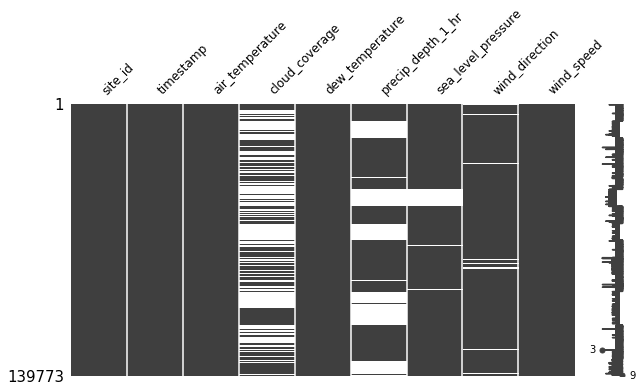

In [173]:
msno.matrix(weather,figsize=(10,5),fontsize=12)

In [174]:
w.timestamp = pd.to_datetime(w['timestamp'])

In [175]:
#w['day'] = w.timestamp.map(lambda x: x.day)
w['month'] = w.timestamp.map(lambda x: x.month)
w['hour'] = w.timestamp.map(lambda x: x.hour)

In [176]:
w["wind_speed"] = w.groupby(["site_id","hour","month"]).transform(lambda x: x.fillna(x.mean()))
w["air_temperature"] = w.groupby(["site_id","hour","month"]).transform(lambda x: x.fillna(x.mean()))


In [177]:
w.isnull().sum() #no null values

site_id            0
timestamp          0
air_temperature    0
wind_speed         0
month              0
hour               0
dtype: int64

In [178]:
w.drop(columns=['month','hour'],inplace=True)

## adding lagged features

In [179]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature','wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [181]:
add_lag_feature(w, window=3)

## Understanding 'ashrae' data

In [182]:
ashrae1 =reduce_mem_usage(ashrae)
a = ashrae1.copy(deep=True)
a.timestamp = pd.to_datetime(a['timestamp'])

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [183]:
a.head(10)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0
5,5,0,2016-01-01,0.0
6,6,0,2016-01-01,0.0
7,7,0,2016-01-01,0.0
8,8,0,2016-01-01,0.0
9,9,0,2016-01-01,0.0


## Merging all the data tables

In [184]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["month"] = X.timestamp.dt.month
    X["year"] = X.timestamp.dt.year
    X.drop(columns=['floor_binary','year_binary'],inplace = True)
    
    return X 

In [185]:
train = prepare_data(a, b, w)  
train = reduce_mem_usage(train)

Mem. usage decreased to 1214.61 Mb (34.4% reduction)


#### Number of data points based on meter type

In [186]:
meter_num = train["meter"].value_counts()
meter_names = ["Electricity", "ChilledWater", "Steam", "HotWater"]
trace = go.Bar(x= meter_names,y = meter_num.values)

layout = go.Layout(title=go.layout.Title(text="Data points for each meter type",x=0.5),font=dict(size=14),width=600,height=400,
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename="meter")

In [187]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()
def make_plot(title, hist, edges, xlabel):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)

    p.y_range.start = 0
    p.xaxis.axis_label = f'{xlabel} meter reading'
    p.yaxis.axis_label = 'Probability'
    p.grid.grid_line_color="white"
    return p

#meter_names = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

#for key, value in meter_names.items():
train_elec = train[train["meter"]==0]
hist, edges = np.histogram(train_elec["meter_reading"].values, density=True, bins=50)
p1 = make_plot("Meter Reading Distribution - Electricity ", hist, edges, "electricity")

train_chilled = train[train["meter"]==1]
hist, edges = np.histogram(train_chilled["meter_reading"].values, density=True, bins=50)
p2 = make_plot("Meter Reading Distribution - Chilled Water", hist, edges, 'chilled water')

train_steam = train[train["meter"]==2]
hist, edges = np.histogram(train_steam["meter_reading"].values, density=True, bins=50)
p3 = make_plot("Meter Reading Distribution - Steam", hist, edges, 'steam')

train_hotwater = train[train["meter"]==3]
hist, edges = np.histogram(train_hotwater["meter_reading"].values, density=True, bins=50)
p4 = make_plot("Meter Reading Distribution - Hot Water", hist, edges, 'hot water')

show(gridplot([p1,p2,p3,p4], ncols=2, plot_width=400, plot_height=400, toolbar_location=None))


Loading BokehJS ...

#### The above distributions are highly skewed. Hence taking a log for each meter reading type and re plotting

In [188]:
train_elec = train[train["meter"]==0]
hist, edges = np.histogram(np.log1p(train_elec["meter_reading"].values), density=True, bins=50)
p1 = make_plot("Meter Reading Distribution - Electricity ", hist, edges, "electricity")

train_chilled = train[train["meter"]==1]
hist, edges = np.histogram(np.log1p(train_chilled["meter_reading"].values), density=True, bins=50)
p2 = make_plot("Meter Reading Distribution - Chilled Water", hist, edges, 'chilled water')

train_steam = train[train["meter"]==2]
hist, edges = np.histogram(np.log1p(train_steam["meter_reading"].values), density=True, bins=50)
p3 = make_plot("Meter Reading Distribution - Steam", hist, edges, 'steam')

train_hotwater = train[train["meter"]==3]
hist, edges = np.histogram(np.log1p(train_hotwater["meter_reading"].values), density=True, bins=50)
p4 = make_plot("Meter Reading Distribution - Hot Water", hist, edges, 'hot water')

show(gridplot([p1,p2,p3,p4], ncols=2, plot_width=400, plot_height=400, toolbar_location=None))

In [189]:
train.groupby('building_id')["meter_reading"].sum().sort_values(ascending=False).head(5)

building_id
1099    3.350620e+10
778     4.404115e+08
1168    4.286342e+08
1197    3.904003e+08
1159    3.142415e+08
Name: meter_reading, dtype: float32

The meter reading of Building_id 1099 is insanely high. Let us explore the pattern of energy consumption of these buildings by each meter type

<Figure size 1008x288 with 0 Axes>

Text(0.5, 1.0, 'Meter readings for building #1099 ')

Text(0.5, 0, 'Sum of readings')

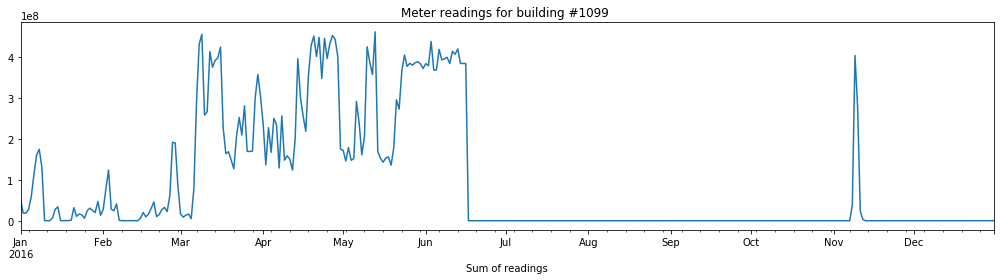

<Figure size 1008x288 with 0 Axes>

Text(0.5, 1.0, 'Meter readings for building #778 ')

Text(0.5, 0, 'Sum of readings')

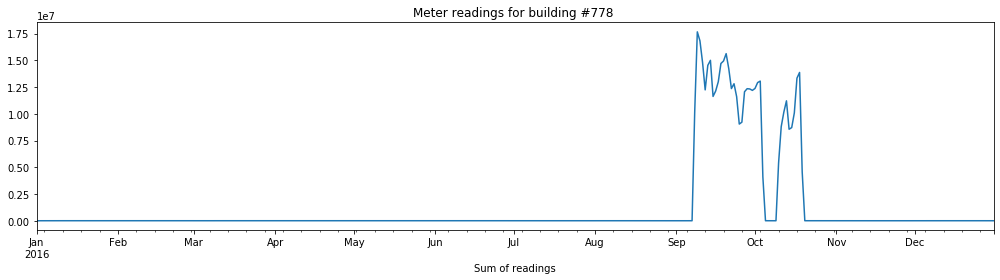

<Figure size 1008x288 with 0 Axes>

Text(0.5, 1.0, 'Meter readings for building #1197 ')

Text(0.5, 0, 'Sum of readings')

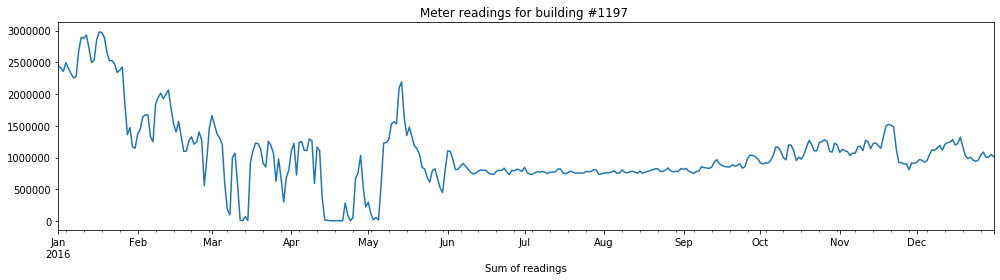

<Figure size 1008x288 with 0 Axes>

Text(0.5, 1.0, 'Meter readings for building #1168 ')

Text(0.5, 0, 'Sum of readings')

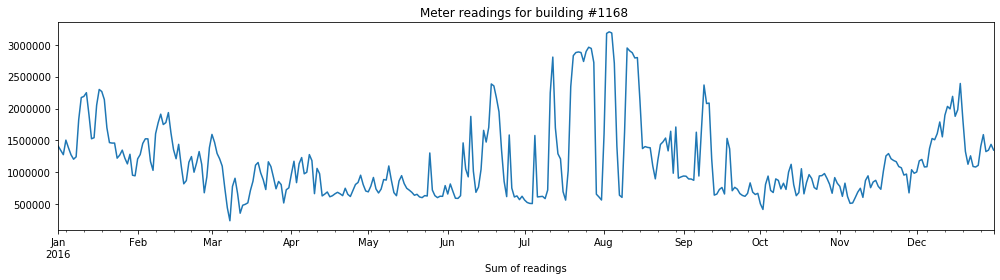

<Figure size 1008x288 with 0 Axes>

Text(0.5, 1.0, 'Meter readings for building #1159 ')

Text(0.5, 0, 'Sum of readings')

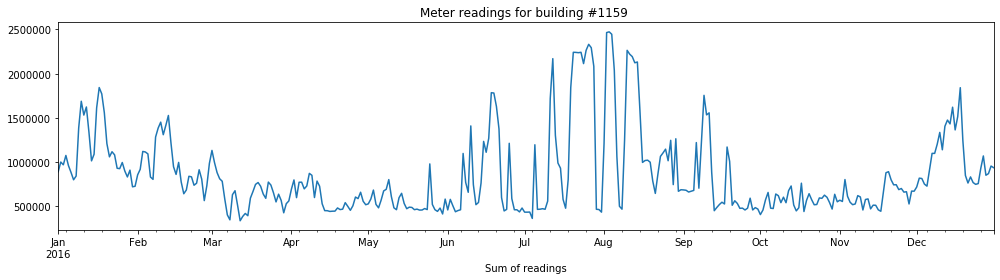

In [190]:
for bldg_id in [1099, 778, 1197, 1168, 1159]:
    plt.figure(figsize=(14,4))
    train_bldg = train[train.building_id == bldg_id].copy()
    train_bldg.set_index("timestamp", inplace=True)
    train_bldg.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()

As meter reading is skewed, lets go about by removing the outliers based on percentiles.

Removing the outliers....

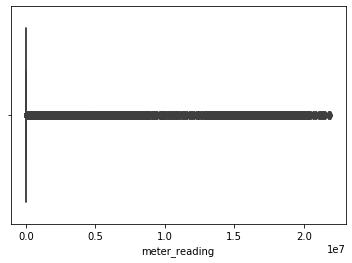

In [191]:
ax = sns.boxplot(x=train["meter_reading"])

In [192]:
# Q1 = train.meter_reading.quantile(0.25)
# Q3 = train.meter_reading.quantile(0.75)
# IQR = Q3 - Q1
# mask = ((train.meter_reading < (Q1 - 1.5 * IQR)) | (train.meter_reading > (Q3 + 1.5 * IQR)))
# ((train.meter_reading < (Q1 - 1.5 * IQR)) | (train.meter_reading > (Q3 + 1.5 * IQR))).sum() # number of outliers
# train.meter_reading.count() #meter_readings

In [193]:
lower    = train["meter_reading"].mean() - train["meter_reading"].std() * 3
upper    = train["meter_reading"].mean() + train["meter_reading"].std() * 3
print(lower,upper)

-457659.1063232422 461636.5186767578


In [194]:
train[train["meter_reading"] < lower].sort_values("meter_reading").building_id.unique()
train[train["meter_reading"] > upper].sort_values("meter_reading").building_id.unique()

array([], dtype=int64)

array([ 778, 1099], dtype=int64)

Building_id 778 and 1099 were outliers. Removing the correspinding data points from further analysis.

In [195]:
mask = ((train.meter_reading > lower) | (train.meter_reading < upper))
train = train[mask]
#train

<Figure size 1584x360 with 0 Axes>

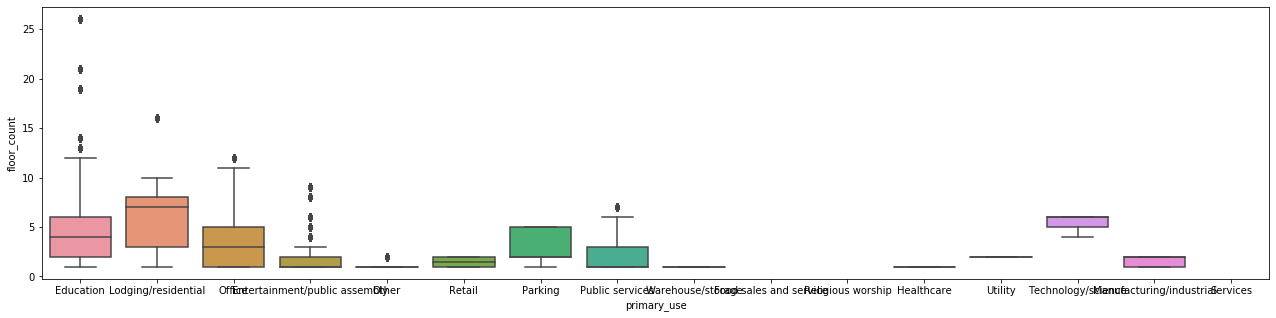

In [196]:
plt.figure(figsize=(22,5))
ax = sns.boxplot(x="primary_use", y="floor_count", data=train)

<Figure size 1440x360 with 0 Axes>

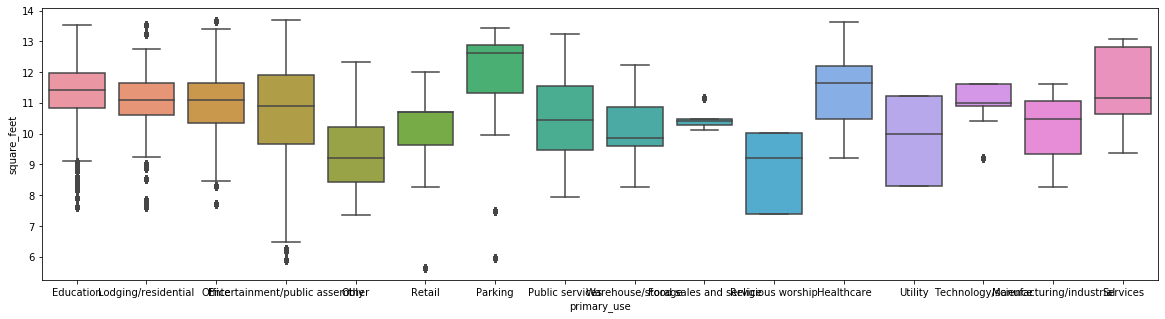

In [197]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="primary_use", y="square_feet", data=train)

<Figure size 1440x360 with 0 Axes>

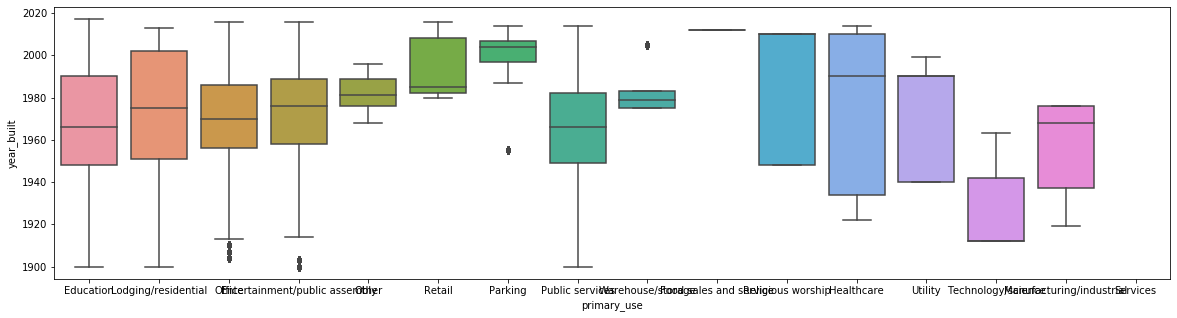

In [198]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="primary_use", y="year_built", data=train)

<Figure size 504x504 with 0 Axes>

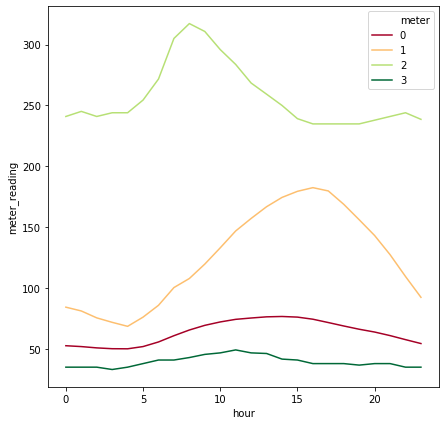

In [199]:

train_hour = train.groupby(['meter','hour'])['meter_reading'].median().reset_index()
plt.figure(figsize=(7,7))
ax = sns.lineplot(x="hour", y="meter_reading", hue="meter",data = train_hour,palette='RdYlGn')
train_hour = train.groupby(['hour'])['meter_reading'].median().reset_index()

<Figure size 504x504 with 0 Axes>

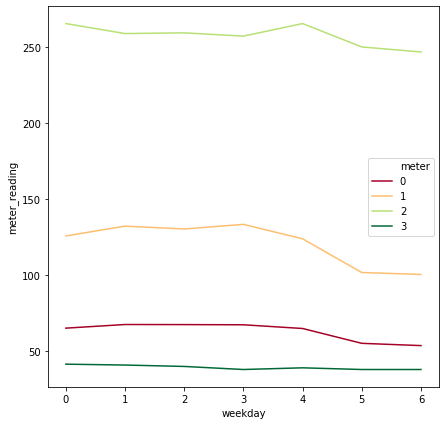

In [200]:
train_weekday = train.groupby(['meter','weekday'])['meter_reading'].median().reset_index()
plt.figure(figsize=(7,7))
ax = sns.lineplot(x="weekday", y="meter_reading", hue="meter",data = train_weekday,palette='RdYlGn')

<Figure size 504x504 with 0 Axes>

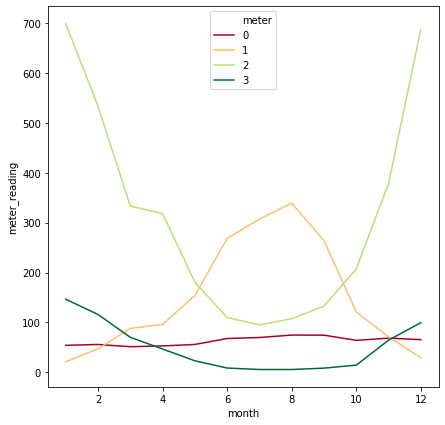

In [201]:
train_month = train.groupby(['meter','month'])['meter_reading'].median().reset_index()
plt.figure(figsize=(7,7))
ax = sns.lineplot(x="month", y="meter_reading", hue="meter",data = train_month,palette='RdYlGn')

Which type of buildings consume a lot of energy ? Looks like Education buildings consume a lot of energy

<Figure size 504x504 with 0 Axes>

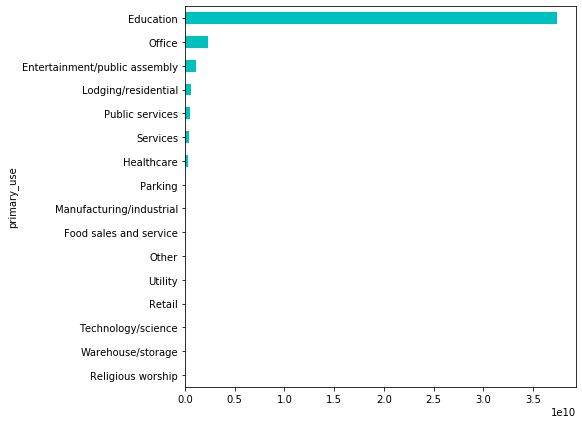

In [202]:
plt.figure(figsize=(7,7))
train.groupby('primary_use')["meter_reading"].sum().sort_values().plot(kind='barh',color='c')

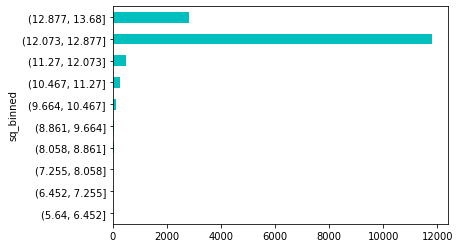

In [203]:
sq_binned = pd.cut(train.square_feet, bins=10)
sq_binned = pd.DataFrame(sq_binned)
sq_binned.columns = ["sq_binned"]
pd.concat([train, sq_binned], axis=1).groupby("sq_binned").meter_reading.mean().sort_index().plot(kind='barh',color='c')

In [204]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,air_temperature_min_lag3,air_temperature_std_lag3,wind_speed_mean_lag3,wind_speed_max_lag3,wind_speed_min_lag3,wind_speed_std_lag3,hour,weekday,month,year
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,8.914062,2008.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,7.910156,2004.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,8.593750,1991.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,10.070312,2002.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,11.664062,1975.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
5,5,0,2016-01-01 00:00:00,0.000000,0,Education,8.984375,2000.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
6,6,0,2016-01-01 00:00:00,0.000000,0,Lodging/residential,10.234375,1981.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
7,7,0,2016-01-01 00:00:00,0.000000,0,Education,11.703125,1989.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
8,8,0,2016-01-01 00:00:00,0.000000,0,Education,11.015625,2003.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016
9,9,0,2016-01-01 00:00:00,0.000000,0,Office,10.203125,2010.0,NaN,25.000000,...,25.000000,NaN,25.000000,25.000000,25.000000,NaN,0,4,1,2016


### Modeling 

### lighGBM

In [205]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import gc

In [260]:
categorical_features = ['meter','building_id','site_id','primary_use','year_built','floor_count','hour','weekday','month']
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.05,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }
target = np.log1p(train["meter_reading"])
features = train.drop(columns=['meter_reading','timestamp'])
features['primary_use'] = features['primary_use'].astype('category')

In [267]:
target.max()
target.min()

16.902212

0.0

In [261]:
kf = KFold(n_splits=5, random_state=111)

models = []
for train_index, val_index in kf.split(features):
    train_X = features.loc[train_index]
    val_X   = target.loc[train_index]
    
    train_y = features.loc[val_index]
    val_y   = target.loc[val_index]
    
    lgb_train = lgb.Dataset(train_X,label= val_X, categorical_feature=categorical_features,free_raw_data=False)
    lgb_eval  = lgb.Dataset(train_y,label= val_y, categorical_feature=categorical_features,free_raw_data=False)
    
    gbm = lgb.train(params,
                train_set=lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50)
    models.append(gbm)
    
    del train_X, val_X, train_y, val_y, lgb_train, lgb_eval
    gc.collect()  

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.986783	valid_1's rmse: 1.14721
[100]	training's rmse: 0.821889	valid_1's rmse: 0.988341
[150]	training's rmse: 0.75958	valid_1's rmse: 0.949134
[200]	training's rmse: 0.732849	valid_1's rmse: 0.93624
[250]	training's rmse: 0.71535	valid_1's rmse: 0.932901
[300]	training's rmse: 0.705143	valid_1's rmse: 0.931119
[350]	training's rmse: 0.695645	valid_1's rmse: 0.929502
[400]	training's rmse: 0.687833	valid_1's rmse: 0.92735
[450]	training's rmse: 0.679925	valid_1's rmse: 0.925936
[500]	training's rmse: 0.673452	valid_1's rmse: 0.925075
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.673452	valid_1's rmse: 0.925075


464

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.965374	valid_1's rmse: 1.35614
[100]	training's rmse: 0.804813	valid_1's rmse: 1.30858
[150]	training's rmse: 0.743226	valid_1's rmse: 1.30082
[200]	training's rmse: 0.714783	valid_1's rmse: 1.30363
Early stopping, best iteration is:
[178]	training's rmse: 0.725362	valid_1's rmse: 1.29649


24

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.95865	valid_1's rmse: 1.10358
[100]	training's rmse: 0.808441	valid_1's rmse: 1.01447
[150]	training's rmse: 0.750862	valid_1's rmse: 0.998798
[200]	training's rmse: 0.723491	valid_1's rmse: 0.996844
[250]	training's rmse: 0.707755	valid_1's rmse: 0.997943
Early stopping, best iteration is:
[200]	training's rmse: 0.723491	valid_1's rmse: 0.996844


300

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.941454	valid_1's rmse: 1.16134
[100]	training's rmse: 0.79124	valid_1's rmse: 1.08664
[150]	training's rmse: 0.731744	valid_1's rmse: 1.06964
[200]	training's rmse: 0.706114	valid_1's rmse: 1.06344
[250]	training's rmse: 0.691254	valid_1's rmse: 1.0623
[300]	training's rmse: 0.6802	valid_1's rmse: 1.06156
[350]	training's rmse: 0.671405	valid_1's rmse: 1.06083
[400]	training's rmse: 0.662903	valid_1's rmse: 1.06013
[450]	training's rmse: 0.655106	valid_1's rmse: 1.0596
[500]	training's rmse: 0.649361	valid_1's rmse: 1.05934
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.649361	valid_1's rmse: 1.05934


438

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.964146	valid_1's rmse: 1.18908


KeyboardInterrupt: 

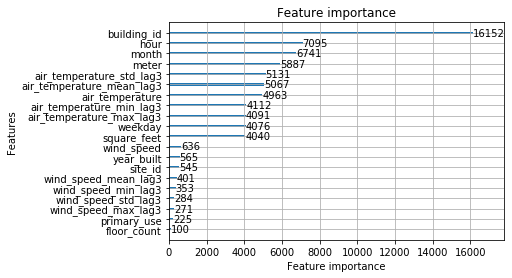

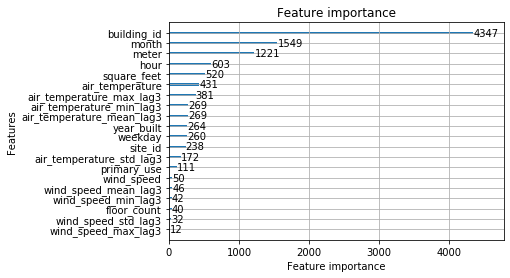

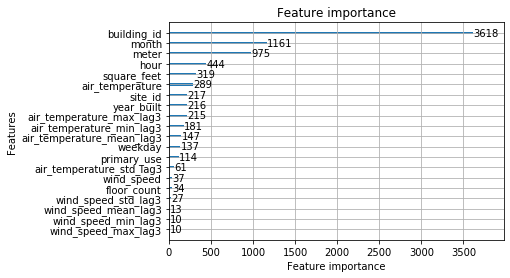

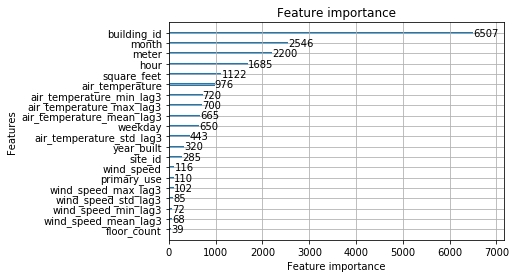

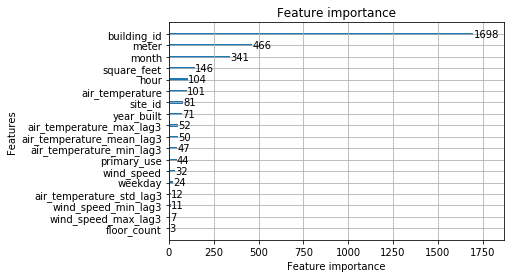

In [208]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

### Test Data

In [230]:
ashrae_test = pd.read_csv('ashrae_test.csv')
weather_test =  pd.read_csv('ashrae_weather_test.csv')

In [231]:
ashrae_test = reduce_mem_usage(ashrae_test)
weather_test = reduce_mem_usage(weather_test)

Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [232]:
ashrae_test.timestamp = pd.to_datetime(ashrae_test['timestamp'])
w_test = weather_test.drop(columns=['cloud_coverage','precip_depth_1_hr','dew_temperature','sea_level_pressure','wind_direction'])
w_test.timestamp = pd.to_datetime(w_test['timestamp'])

In [233]:
w_test['month'] = w_test.timestamp.map(lambda x: x.month)
w_test['hour'] = w_test.timestamp.map(lambda x: x.hour)

In [234]:
w_test["wind_speed"] = w_test.groupby(["site_id","hour","month"]).transform(lambda x: x.fillna(x.mean()))
w_test["air_temperature"] = w_test.groupby(["site_id","hour","month"]).transform(lambda x: x.fillna(x.mean()))

In [235]:
add_lag_feature(w_test, window=3)

In [236]:
w_test = w_test.drop(columns=['month','hour'])

In [237]:
test = prepare_data(ashrae_test, b, w_test)  
test = reduce_mem_usage(test)

Mem. usage decreased to 2505.25 Mb (34.4% reduction)


In [248]:
test = test.drop(columns=['row_id','timestamp'])

In [253]:
test['primary_use'] = test['primary_use'].astype('category')

In [252]:
features.dtypes

building_id                     int16
meter                            int8
site_id                          int8
primary_use                  category
square_feet                   float16
year_built                    float16
floor_count                   float16
air_temperature               float16
wind_speed                    float16
air_temperature_mean_lag3     float16
air_temperature_max_lag3      float16
air_temperature_min_lag3      float16
air_temperature_std_lag3      float16
wind_speed_mean_lag3          float16
wind_speed_max_lag3           float16
wind_speed_min_lag3           float16
wind_speed_std_lag3           float16
hour                             int8
weekday                          int8
month                            int8
year                            int16
dtype: object

### Prediction 

In [254]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

11515

33

33

33

33

In [256]:
submission = pd.read_csv('ashrae_sample_submission.csv')

In [257]:
submission['meter_reading'] = np.clip(results, 0, a_max=None)

In [258]:
submission.to_csv('submission_SS.csv', index=False)

In [262]:
submission.head(10)

,row_id,meter_reading
0,0,5.377084
1,1,2.996488
2,2,0.705352
3,3,2.911490
4,4,3.289553
5,5,1.044040
6,6,2.809556
7,7,2.797885
8,8,306.309879
9,9,5.824615
